# RATIO 2019 - Benchmarking Workshop

https://gluon-nlp.mxnet.io/install.html

```
pip install --upgrade 'mxnet>=1.3.0'
pip install gluonnlp
wget https://gluon-nlp.mxnet.io/_downloads/sentence_embedding.zip
unzip sentence_embedding.zip
ln -s sentence_embedding/bert bert
```

In [43]:
import datetime
import logging
import os
import random
import time
import warnings

import csv
import gluonnlp as nlp
import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
import pandas as pd
import seaborn as sns

from bert import *
from mxnet import gluon
from mxnet.gluon.data import Dataset, SimpleDataset
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score)
from sklearn.model_selection import train_test_split
from sklearn import utils
from tqdm import tqdm

In [44]:
warnings.filterwarnings('ignore')

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s',
                    level=logging.INFO)

In [45]:
# set repeatable random state
np.random.seed(100)
random.seed(100)
mx.random.seed(10000)

In [46]:
# apply progress bars for pandas .apply() -> .progress_apply()
tqdm.pandas()

In [47]:
# make tqdm jupyter friendly
from tqdm import tqdm_notebook as tqdm
# for .progress_apply() we have to hack it like this?
tqdm().pandas()

In [48]:
class Timer:
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.time_start = time.time()

    def __exit__(self, *exc):
        time_end = time.time()
        time_delta = datetime.timedelta(seconds=(time_end - self.time_start))
        if self.name:
            print(("Time for [{}]: {}".format(self.name, time_delta)))
        else:
            print(("Time: {}".format(time_delta)))

# Task 1 - Same Side Classification

In [49]:
data_cross_path = 'data/same-side-classification/cross-topic/{}.csv'
data_within_path = 'data/same-side-classification/within-topic/{}.csv'

### Load within-topics and cross-topics data

In [50]:
# escapechar to detect quoting escapes, else it fails

# na_filter=False, because pandas automatic "nan" detection fails with the topic column, too
# cross_test_df['topic'].astype(str)[9270]

# within has "is_same_side" as string (boolean after latest update)
# cross has "is_same_side" as boolean (auto cast?)

with Timer("read cross"):
    # cross_traindev_df = pd.read_csv(data_cross_path.format('training'), index_col='id', escapechar='\\', na_filter=False)
    # cross_test_df = pd.read_csv(data_cross_path.format('test'), index_col='id', escapechar='\\', na_filter=False)
    cross_traindev_df = pd.read_csv(data_cross_path.format('training'),
                                    quotechar='"',
                                    quoting=csv.QUOTE_ALL,
                                    encoding='utf-8',
                                    escapechar='\\',
                                    doublequote=False,
                                    index_col='id')
    cross_test_df = pd.read_csv(data_cross_path.format('test'),
                                quotechar='"',
                                quoting=csv.QUOTE_ALL,
                                encoding='utf-8',
                                escapechar='\\',
                                doublequote=False,
                                index_col='id')

with Timer("read within"):
    # within_traindev_df = pd.read_csv(data_within_path.format('training'), index_col='id', escapechar='\\', na_filter=False)
    # within_test_df = pd.read_csv(data_within_path.format('test'), index_col='id', escapechar='\\', na_filter=False)
    within_traindev_df = pd.read_csv(data_within_path.format('training'),
                                     quotechar='"',
                                     quoting=csv.QUOTE_ALL,
                                     encoding='utf-8',
                                     escapechar='\\',
                                     doublequote=False,
                                     index_col='id')
    within_test_df = pd.read_csv(data_within_path.format('test'),
                                 quotechar='"',
                                 quoting=csv.QUOTE_ALL,
                                 encoding='utf-8',
                                 escapechar='\\',
                                 doublequote=False,
                                 index_col='id')

Time for [read cross]: 0:00:01.097146
Time for [read within]: 0:00:01.159655


In [51]:
# Adding a tag for the topics in focus: "gay marriage" and "abortion"
def add_tag(row):
    title = row['topic'].lower().strip()
    if "abortion" in title:
        row['tag'] = 'abortion'
    elif "gay marriage"  in title:
        row['tag'] = 'gay marriage'
    else:
        row['tag'] = 'NA'
    return row


with Timer("tag cross traindev"):
    cross_traindev_df = cross_traindev_df.progress_apply(add_tag, axis=1)
with Timer("tag cross test"):
    cross_test_df = cross_test_df.progress_apply(add_tag, axis=1)

with Timer("tag within traindev"):
    within_traindev_df = within_traindev_df.progress_apply(add_tag, axis=1)
with Timer("tag within test"):
    within_test_df = within_test_df.progress_apply(add_tag, axis=1)


Time for [tag cross traindev]: 0:00:34.304106



Time for [tag cross test]: 0:00:19.343720



Time for [tag within traindev]: 0:00:36.578005



Time for [tag within test]: 0:00:17.689106


## Train model - Baseline

### train dev set - 70% 30%

In [52]:
def get_train_test_sets(df, ratio=0.30, random_state=1):
    X = df[['argument1', 'argument2', 'argument1_id', 'argument2_id', 'topic']]
    y = df[['is_same_side']]

    X_train, X_test, y_train, y_test = train_test_split(X,
                                                        y,
                                                        test_size=ratio,
                                                        random_state=random_state,
                                                        shuffle=True)
    return X_train, X_test, y_train, y_test

### BERT

- https://gluon-nlp.mxnet.io/examples/sentence_embedding/bert.html

In [53]:
class MyBERTDataset(SimpleDataset):
    def __init__(self, X, y=None):
        self._X = X
        self._y = y
        super(MyBERTDataset, self).__init__(self._convert())

    def _convert(self):
        allsamples = list()

        if self._y is not None:
            df = self._X.merge(self._y, left_index=True, right_index=True)
            for _, row in df.iterrows():
                allsamples.append([
                    row['argument1'], row['argument2'],
                    "1" if str(row['is_same_side']) == "True" else "0"
                ])
        else:
            for _, row in self._X.iterrows():
                allsamples.append([row['argument1'], row['argument2'], None])

        return allsamples

In [54]:
from gluonnlp.data import BERTSentenceTransform


class MiddlePartBERTSentenceTransform(BERTSentenceTransform):
    def __init__(self, tokenizer, max_seq_length, pad=True, pair=True):
        super(MiddlePartBERTSentenceTransform, self).__init__(tokenizer, max_seq_length, pad=pad, pair=pair)


    def _truncate_seq_pair(self, tokens_a, tokens_b, max_length):
        """Truncates a sequence pair in place to the maximum length.
        Removes from end of token list."""
        # This is a simple heuristic which will always truncate the longer sequence
        # two tokens at a time. This makes more sense than truncating an equal percent
        # of tokens from each, since if one sequence is very short then each token
        # that's truncated likely contains more information than a longer sequence.
        while True:
            total_length = len(tokens_a) + len(tokens_b)
            if total_length <= max_length:
                break
            if len(tokens_a) > len(tokens_b):
                tokens_a.pop()
                tokens_a.pop(0)
            else:
                tokens_b.pop()
                tokens_b.pop(0)

In [55]:
class MiddlePartBERTDatasetTransform(dataset.BERTDatasetTransform):
    def __init__(self, tokenizer, max_seq_length, labels=None, pad=True, pair=True, label_dtype='float32'):
        super(MiddlePartBERTDatasetTransform, self).__init__(tokenizer, max_seq_length, labels=labels, pad=pad, pair=pair, label_dtype=label_dtype)
        self._bert_xform = MiddlePartBERTSentenceTransform(tokenizer, max_seq_length, pad=pad, pair=pair)

In [56]:
def setup_bert():
    # change `ctx` to `mx.cpu()` if no GPU is available.
    ctx = mx.gpu(0)
    # ctx =  mx.gpu() if mx.context.num_gpus() else mx.cpu()
    # ctx = mx.cpu()
    
    bert_base, vocabulary = nlp.model.get_model('bert_12_768_12',
                                                 dataset_name='book_corpus_wiki_en_uncased',
                                                 pretrained=True, ctx=ctx, use_pooler=True,
                                                 use_decoder=False, use_classifier=False)
    print(bert_base)
    
    model = bert.BERTClassifier(bert_base, num_classes=2, dropout=0.1)
    # only need to initialize the classifier layer.
    model.classifier.initialize(init=mx.init.Normal(0.02), ctx=ctx)
    model.hybridize(static_alloc=True)

    # softmax cross entropy loss for classification
    loss_function = gluon.loss.SoftmaxCELoss()
    loss_function.hybridize(static_alloc=True)

    metric = mx.metric.Accuracy()
    
    # use the vocabulary from pre-trained model for tokenization
    bert_tokenizer = nlp.data.BERTTokenizer(vocabulary, lower=True)
    # maximum sequence length
    # max_len = 128  # + batch_size: 32
    max_len = 512  # + batch_size: 6 ?
    # the labels for the two classes
    all_labels = ["0", "1"]
    # whether to transform the data as sentence pairs.
    # for single sentence classification, set pair=False
    transform = MiddlePartBERTDatasetTransform(bert_tokenizer, max_len,
                                               labels=all_labels,
                                               label_dtype='int32',
                                               pad=True,
                                               pair=True)

    return model, vocabulary, ctx, bert_tokenizer, transform, loss_function, metric, all_labels

In [57]:
def transform_dataset(X, y, transform):
    data_train_raw = MyBERTDataset(X, y)
    data_train = data_train_raw.transform(transform)
    return data_train_raw, data_train


def predict_out_to_ys(all_predictions, all_labels):
    y_true, y_pred = list(), list()
    
    for _, y_true_many, y_pred_many in all_predictions:
        y_true_many = y_true_many.T[0].asnumpy()
        # https://mxnet.incubator.apache.org/api/python/gluon/loss.html#mxnet.gluon.loss.SoftmaxCrossEntropyLoss
        # pred: the prediction tensor, where the batch_axis dimension ranges over batch size and axis dimension ranges over the number of classes.
        y_pred_many = np.argmax(y_pred_many, axis=1).asnumpy()

        y_true.extend(list(y_true_many))
        y_pred.extend(list(y_pred_many))
        # TODO: convert label_id to label?
        # y_pred.extend(all_labels[c] for c in list(y_pred_many))
        
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    
    return y_true, y_pred

In [58]:
def train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=3, checkpoint_dir="data", use_checkpoints=True):
    with Timer("setup training"):
        train_sampler = nlp.data.FixedBucketSampler(
            lengths=[int(item[1]) for item in tqdm(data_train)],
            batch_size=batch_size,
            shuffle=True)
        bert_dataloader = mx.gluon.data.DataLoader(data_train,
                                                   batch_sampler=train_sampler)

        trainer = gluon.Trainer(model.collect_params(), 'adam', {
            'learning_rate': lr,
            'epsilon': 1e-9
        })

        # collect all differentiable parameters
        # grad_req == 'null' indicates no gradients are calculated (e.g. constant parameters)
        # the gradients for these params are clipped later
        params = [p for p in model.collect_params().values() if p.grad_req != 'null']

    log_interval = 300
    with Timer("training"):
        stats = list()
        for epoch_id in range(num_epochs):
            if use_checkpoints:
                epoch_checkpoint_savefile = "bert.model.checkpoint{}.params".format(epoch_id)
                if checkpoint_dir is not None:
                    epoch_checkpoint_savefile = os.path.join(checkpoint_dir, epoch_checkpoint_savefile)
                if os.path.exists(epoch_checkpoint_savefile):
                    model.load_parameters(epoch_checkpoint_savefile, ctx=ctx)
                    print("loaded checkpoint for epoch {}".format(epoch_id))
                    continue

            with Timer("epoch {}".format(epoch_id)):
                metric.reset()
                step_loss = 0
                t_p = time.time()  # time keeping
                for batch_id, (token_ids, valid_length, segment_ids,
                               label) in enumerate(tqdm(bert_dataloader)):
                    with mx.autograd.record():

                        # load data to GPU
                        token_ids = token_ids.as_in_context(ctx)
                        valid_length = valid_length.as_in_context(ctx)
                        segment_ids = segment_ids.as_in_context(ctx)
                        label = label.as_in_context(ctx)

                        # forward computation
                        out = model(token_ids, segment_ids,
                                    valid_length.astype('float32'))
                        ls = loss_function(out, label).mean()

                    # backward computation
                    ls.backward()

                    # gradient clipping
                    trainer.allreduce_grads()
                    nlp.utils.clip_grad_global_norm(params, 1)
                    trainer.update(1)

                    step_loss += ls.asscalar()
                    metric.update([label], [out])
                    stats.append((metric.get()[1], ls.asscalar()))
                    if (batch_id + 1) % (log_interval) == 0:
                        print(
                            '[Epoch {} Batch {}/{}] loss={:.4f}, lr={:.7f}, acc={:.3f} - time {}'
                            .format(epoch_id, batch_id + 1, len(bert_dataloader),
                                    step_loss / log_interval, trainer.learning_rate,
                                    metric.get()[1],
                                    datetime.timedelta(seconds=(time.time() - t_p))))
                        t_p = time.time()
                        step_loss = 0

            if use_checkpoints:
                model.save_parameters(epoch_checkpoint_savefile)
            
    return stats

In [59]:
def predict(model, data_predict, ctx, metric, loss_function, batch_size=32):
    bert_dataloader = mx.gluon.data.DataLoader(data_predict, batch_size=batch_size)
    
    all_predictions = list()

    with Timer("prediction"):
        metric.reset()
        cum_loss = 0
        for batch_id, (token_ids, valid_length, segment_ids,
                       label) in enumerate(tqdm(bert_dataloader)):
            # load data to GPU
            token_ids = token_ids.as_in_context(ctx)
            valid_length = valid_length.as_in_context(ctx)
            segment_ids = segment_ids.as_in_context(ctx)
            label = label.as_in_context(ctx)

            # forward computation
            out = model(token_ids, segment_ids,
                        valid_length.astype('float32'))
            ls = loss_function(out, label).mean()

            metric.update([label], [out])
            cum_loss += ls.asscalar()  # .sum() ?
            all_predictions.append((batch_id, label, out))
            
    return all_predictions, cum_loss

In [60]:
def print_infos(vocabulary, data_train_raw, data_train):
    sample_id = 0

    # sentence a
    print(data_train_raw[sample_id][0])
    # sentence b
    print(data_train_raw[sample_id][1])
    # 1 means equivalent, 0 means not equivalent
    print(data_train_raw[sample_id][2])

    print('vocabulary used for tokenization = \n%s'%vocabulary)
    print('[PAD] token id = %s'%(vocabulary['[PAD]']))
    print('[CLS] token id = %s'%(vocabulary['[CLS]']))
    print('[SEP] token id = %s'%(vocabulary['[SEP]']))

    print('token ids = \n%s'%data_train[sample_id][0])
    print('valid length = \n%s'%data_train[sample_id][1])
    print('segment ids = \n%s'%data_train[sample_id][2])
    print('label = \n%s'%data_train[sample_id][3])
    

def plot_train_stats(stats):
    if not stats:
        print("no stats to plot")
        return

    x = np.arange(len(stats))  # arange/linspace

    acc_dots, loss_dots = zip(*stats)

    plt.subplot(2, 1, 1)
    plt.plot(x, acc_dots)  # Linie: '-', 'o-', '.-'
    plt.title('Training BERTClassifier')
    plt.ylabel('Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(x, loss_dots)
    plt.xlabel('Batches')
    plt.ylabel('Loss')

    plt.show()

### Evaluate

In [61]:
def heatconmat(y_test, y_pred):
    sns.set_context('talk')
    plt.figure(figsize=(9, 6))
    sns.heatmap(confusion_matrix(y_test, y_pred),
                annot=True,
                fmt='d',
                cbar=False,
                cmap='gist_earth_r',
                yticklabels=sorted(np.unique(y_test)))
    plt.show()


def report_training_results(y_test, y_pred, name=None, heatmap=True):
    print('Confusion Matrix:')
    print(confusion_matrix(y_test, y_pred))
    if heatmap:
        heatconmat(y_test, y_pred)
    print()
    print('Accuracy: ', round(accuracy_score(y_test, y_pred), 2), '\n')  #

    print('Report{}:'.format("" if not name else " for [{}]".format(name)))
    print(classification_report(y_test, y_pred))

    f1_dic = {}
    f1_dic['macro'] = round(
        f1_score(y_pred=y_pred, y_true=y_test, average='macro'), 2)
    f1_dic['micro'] = round(
        f1_score(y_pred=y_pred, y_true=y_test, average='micro'), 2)
    return f1_dic

### Within topic - Training and evaluating model 

In [20]:
# 1. Getting train and dev data
with Timer("1 - test/train split"):
    X_train, X_dev, y_train, y_dev = get_train_test_sets(within_traindev_df)

Time for [1 - test/train split]: 0:00:00.023732


In [21]:
# 2. setup
with Timer("2 - setup BERT model"):
    model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert()

BERTModel(
  (encoder): BERTEncoder(
    (dropout_layer): Dropout(p = 0.1, axes=())
    (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
    (transformer_cells): HybridSequential(
      (0): BERTEncoderCell(
        (dropout_layer): Dropout(p = 0.1, axes=())
        (attention_cell): MultiHeadAttentionCell(
          (_base_cell): DotProductAttentionCell(
            (_dropout_layer): Dropout(p = 0.1, axes=())
          )
          (proj_query): Dense(768 -> 768, linear)
          (proj_key): Dense(768 -> 768, linear)
          (proj_value): Dense(768 -> 768, linear)
        )
        (proj): Dense(768 -> 768, linear)
        (ffn): BERTPositionwiseFFN(
          (ffn_1): Dense(768 -> 3072, linear)
          (activation): GELU()
          (ffn_2): Dense(3072 -> 768, linear)
          (dropout_layer): Dropout(p = 0.1, axes=())
          (layer_norm): BERTLayerNorm(eps=1e-12, axis=-1, center=True, scale=True, in_channels=768)
        )
        (la

In [22]:
with Timer("3 - prepare training data"):
    data_train_raw, data_train = transform_dataset(X_train, y_train, transform)
    print_infos(vocabulary, data_train_raw, data_train)

wanted fetuses are beloved "babies"; unwanted ones are "tissue" (inconsistent)
abortions are emotionally and psychologically unsafe.
1
vocabulary used for tokenization = 
Vocab(size=30522, unk="[UNK]", reserved="['[PAD]', '[CLS]', '[SEP]', '[MASK]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
token ids = 
[    2  2359 10768  5809  2229  2024 11419  1000 10834  1000  1025 18162
  3924  2024  1000  8153  1000  1006 20316  1007     3 11324  2015  2024
 14868  1998  8317  2135 25135  1012     3     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1     1     1     1     1     1     1     1     1     1
     1     1     1   


Time for [setup training]: 0:03:05.833237
loaded checkpoint for epoch 0


[Epoch 1 Batch 300/7459] loss=0.3101, lr=0.0000050, acc=0.825 - time 0:04:23.971195
[Epoch 1 Batch 600/7459] loss=0.3020, lr=0.0000050, acc=0.826 - time 0:04:23.230661
[Epoch 1 Batch 900/7459] loss=0.2970, lr=0.0000050, acc=0.829 - time 0:04:23.854026
[Epoch 1 Batch 1200/7459] loss=0.2955, lr=0.0000050, acc=0.837 - time 0:04:23.769608
[Epoch 1 Batch 1500/7459] loss=0.3031, lr=0.0000050, acc=0.838 - time 0:04:24.070495
[Epoch 1 Batch 1800/7459] loss=0.3151, lr=0.0000050, acc=0.838 - time 0:04:24.602069
[Epoch 1 Batch 2100/7459] loss=0.3161, lr=0.0000050, acc=0.837 - time 0:04:25.391182
[Epoch 1 Batch 2400/7459] loss=0.3017, lr=0.0000050, acc=0.837 - time 0:04:25.448332
[Epoch 1 Batch 2700/7459] loss=0.2808, lr=0.0000050, acc=0.839 - time 0:04:24.769686
[Epoch 1 Batch 3000/7459] loss=0.2782, lr=0.0000050, acc=0.842 - time 0:04:25.255252
[Epoch 1 Batch 3300/7459] loss=0.2676, lr=0.0000050, acc=0.845 - time 0:04:23.653459
[Epoch 1 Batch 3600/7459] loss=0.3192, lr=0.0000050, acc=0.844 - tim

[Epoch 2 Batch 300/7459] loss=0.2474, lr=0.0000050, acc=0.897 - time 0:04:25.059841
[Epoch 2 Batch 600/7459] loss=0.2423, lr=0.0000050, acc=0.895 - time 0:04:25.224910
[Epoch 2 Batch 900/7459] loss=0.2590, lr=0.0000050, acc=0.890 - time 0:04:26.536187
[Epoch 2 Batch 1200/7459] loss=0.2572, lr=0.0000050, acc=0.891 - time 0:04:24.941209
[Epoch 2 Batch 1500/7459] loss=0.2517, lr=0.0000050, acc=0.891 - time 0:04:25.505545
[Epoch 2 Batch 1800/7459] loss=0.2529, lr=0.0000050, acc=0.890 - time 0:04:25.312696
[Epoch 2 Batch 2100/7459] loss=0.2710, lr=0.0000050, acc=0.888 - time 0:04:25.819212
[Epoch 2 Batch 2400/7459] loss=0.2561, lr=0.0000050, acc=0.888 - time 0:04:25.821377
[Epoch 2 Batch 2700/7459] loss=0.2811, lr=0.0000050, acc=0.887 - time 0:04:26.523284
[Epoch 2 Batch 3000/7459] loss=0.2458, lr=0.0000050, acc=0.887 - time 0:04:26.004571
[Epoch 2 Batch 3300/7459] loss=0.2600, lr=0.0000050, acc=0.888 - time 0:04:24.683110
[Epoch 2 Batch 3600/7459] loss=0.2356, lr=0.0000050, acc=0.889 - tim

[Epoch 3 Batch 300/7459] loss=0.2012, lr=0.0000050, acc=0.933 - time 0:04:24.555556
[Epoch 3 Batch 600/7459] loss=0.1947, lr=0.0000050, acc=0.927 - time 0:04:25.320385


IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



[Epoch 3 Batch 6300/7459] loss=0.2351, lr=0.0000050, acc=0.917 - time 0:04:24.249716
[Epoch 3 Batch 6600/7459] loss=0.2032, lr=0.0000050, acc=0.917 - time 0:04:24.026482
[Epoch 3 Batch 6900/7459] loss=0.1817, lr=0.0000050, acc=0.918 - time 0:04:23.779357
[Epoch 3 Batch 7200/7459] loss=0.2199, lr=0.0000050, acc=0.917 - time 0:04:25.502182

Time for [epoch 3]: 1:49:54.631470


[Epoch 4 Batch 300/7459] loss=0.1655, lr=0.0000050, acc=0.942 - time 0:04:25.151816
[Epoch 4 Batch 600/7459] loss=0.1666, lr=0.0000050, acc=0.943 - time 0:04:23.776129
[Epoch 4 Batch 900/7459] loss=0.1712, lr=0.0000050, acc=0.942 - time 0:04:25.151824
[Epoch 4 Batch 1200/7459] loss=0.1953, lr=0.0000050, acc=0.942 - time 0:04:25.257615
[Epoch 4 Batch 1500/7459] loss=0.2254, lr=0.0000050, acc=0.939 - time 0:04:25.780583
[Epoch 4 Batch 1800/7459] loss=0.1653, lr=0.0000050, acc=0.940 - time 0:04:24.611233
[Epoch 4 Batch 2100/7459] loss=0.1335, lr=0.0000050, acc=0.943 - time 0:04:23.383859
[Epoch 4 Batch 2400/7459] loss=0.1808, lr=0.0000050, acc=0.943 - time 0:04:23.259588
[Epoch 4 Batch 2700/7459] loss=0.1745, lr=0.0000050, acc=0.943 - time 0:04:25.802622
[Epoch 4 Batch 3000/7459] loss=0.2128, lr=0.0000050, acc=0.941 - time 0:04:26.327539
[Epoch 4 Batch 3300/7459] loss=0.1879, lr=0.0000050, acc=0.941 - time 0:04:27.056316
[Epoch 4 Batch 3600/7459] loss=0.1552, lr=0.0000050, acc=0.941 - tim

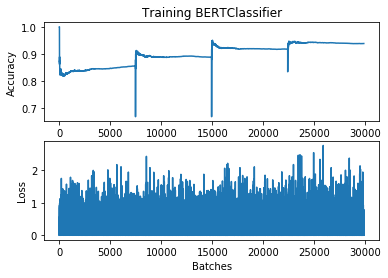

Time for [4 - train model]: 7:29:59.145579


In [23]:
with Timer("4 - train model"):
    # train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=3)
    stats = train(model, data_train, ctx, metric, loss_function, batch_size=6, lr=5e-6, num_epochs=5, checkpoint_dir="data/within_traindev_mid512")
    # model.save_parameters("data/same-side-classification/within-topic/bert.model.params")
    model.save_parameters("data/within_traindev_mid512/bert.model.params")

    plot_train_stats(stats)

In [62]:
with Timer("5 - prepare eval data"):
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    print_infos(vocabulary, data_dev_raw, data_dev)

abortion opens the door to the sexual exploitation of women the existence of abortion gives men a little more of a safeguard against unintentionally impregnating a woman. as a result, men will be more aggressive in their sexual exploitation of women.
the fact that a child is likely to have a short life does not justify further shortening it:
0
vocabulary used for tokenization = 
Vocab(size=30522, unk="[UNK]", reserved="['[PAD]', '[CLS]', '[SEP]', '[MASK]']")
[PAD] token id = 1
[CLS] token id = 2
[SEP] token id = 3
token ids = 
[    2 11324  7480  1996  2341  2000  1996  4424 14427  1997  2308  1996
  4598  1997 11324  3957  2273  1037  2210  2062  1997  1037 28805  2114
  4895 18447  4765 19301  2135 17727  2890 16989  3436  1037  2450  1012
  2004  1037  2765  1010  2273  2097  2022  2062  9376  1999  2037  4424
 14427  1997  2308  1012     3  1996  2755  2008  1037  2775  2003  3497
  2000  2031  1037  2460  2166  2515  2025 16114  2582  2460  7406  2009
  1024     3     1     1     

In [63]:
with Timer("6 - evaluate"):
    # model.load_parameters("data/same-side-classification/within-topic/bert.model.params", ctx=ctx)
    #model.load_parameters("data/within_traindev_mid512/bert.model.params", ctx=ctx)
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
    print("Accuracy:", metric.get()[1])

    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name="BERTClassifier", heatmap=False)


Time for [prediction]: 0:09:49.406347
Accuracy: 0.8796619894632518
Confusion Matrix:
[[8181  652]
 [1655 8683]]

Accuracy:  0.88 

Report for [BERTClassifier]:
              precision    recall  f1-score   support

           0       0.83      0.93      0.88      8833
           1       0.93      0.84      0.88     10338

    accuracy                           0.88     19171
   macro avg       0.88      0.88      0.88     19171
weighted avg       0.88      0.88      0.88     19171

Time for [6 - evaluate]: 0:09:49.633114


### Train and evaluate each epoch

In [ ]:
for epoch_id in range(5):
    with Timer("4 - train model - {}".format(epoch_id)):
        # stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=epoch_id + 1)
        stats = train(model, data_train, ctx, metric, loss_function, batch_size=6, lr=5e-6, num_epochs=epoch_id + 1)  # seq_len: 512
        plot_train_stats(stats)

    with Timer("6 - evaluate - {}".format(epoch_id)):
        # all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
        all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=6)  # seq_len: 512
        print("Accuracy in epoch {}:".format(epoch_id), metric.get()[1])
        y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
        report_training_results(y_true, y_pred, name="BERTClassifier - middle part", heatmap=False)

    model.save_parameters("data/bert.model.params")

In [ ]:
for epoch_id in range(5):
    with Timer("4 - train model - {}".format(epoch_id)):
        # stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=epoch_id + 1)
        stats = train(model, data_train, ctx, metric, loss_function, batch_size=6, lr=5e-6, num_epochs=epoch_id + 1)  # seq_len: 512
        plot_train_stats(stats)

    with Timer("6 - evaluate - {}".format(epoch_id)):
        # all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
        all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function, batch_size=6)  # seq_len: 512
        print("Accuracy in epoch {}:".format(epoch_id), metric.get()[1])
        y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
        report_training_results(y_true, y_pred, name="BERTClassifier - last part", heatmap=False)

    model.save_parameters("data/bert.model.params")

*may need to use **binary_cross_entrophy**?* (can I use a single label or do I have to use "0" and "1"?)

### Cross topic - Training and evaluating model 

In [ ]:
# 1. Getting train and dev data
with Timer("1 - test/train split"):
    X_train, X_dev, y_train, y_dev = get_train_test_sets(cross_traindev_df)

In [ ]:
# 2. setup
with Timer("2 - setup BERT model"):
    model, vocabulary, ctx, tokenizer, transform, loss_function, metric, all_labels = setup_bert()

In [ ]:
with Timer("3 - prepare training data"):
    data_train_raw, data_train = transform_dataset(X_train, y_train, transform)
    print_infos(vocabulary, data_train_raw, data_train)

In [ ]:
with Timer("4 - train model"):
    # train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=3)
    stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=2)
    # model.save_parameters("data/same-side-classification/cross-topic/bert.model.params")
    model.save_parameters("data/bert.model.params")

    plot_train_stats(stats)

In [ ]:
with Timer("5 - prepare eval data"):
    data_dev_raw, data_dev = transform_dataset(X_dev, y_dev, transform)
    print_infos(vocabulary, data_dev_raw, data_dev)

In [ ]:
with Timer("6 - evaluate"):
    # model.load_parameters("data/same-side-classification/cross-topic/bert.model.params", ctx=ctx)
    model.load_parameters("data/bert.model.params", ctx=ctx)
    all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
    print("Accuracy:", metric.get()[1])

    y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
    report_training_results(y_true, y_pred, name="BERTClassifier", heatmap=False)

In [ ]:
for epoch_id in range(5):
    with Timer("4 - train model - {}".format(epoch_id)):
        stats = train(model, data_train, ctx, metric, loss_function, batch_size=32, lr=5e-6, num_epochs=epoch_id + 1)
        plot_train_stats(stats)

    with Timer("6 - evaluate - {}".format(epoch_id)):
        all_predictions, cum_loss = predict(model, data_dev, ctx, metric, loss_function)
        print("Accuracy in epoch {}:".format(epoch_id), metric.get()[1])
        y_true, y_pred = predict_out_to_ys(all_predictions, all_labels)
        report_training_results(y_true, y_pred, name="BERTClassifier", heatmap=False)

    model.save_parameters("data/bert.model.params")